In [3]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import models 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

/home/sean/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sean/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sean/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sean/anaconda3/envs/tf-gpu-c

In [4]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
cut = 1300
train_data_x , train_data_y  = train_data.iloc[cut:,:-1].copy(), train_data.iloc[cut:,-1].copy()
val_data_x , val_data_y = train_data.iloc[:cut,:-1].copy(), train_data.iloc[:cut,-1].copy()
test_data_x  = test_data



All numerical data can be easily normalized. 
for the non nunmerical entries, The number of unique entries should be considered. 

To Do
-Plot input data 
-stdev

## Functions For Processing Input data 
Data is normalised either with some form of gaussian or between 0-1 depending on what it is

In [5]:
def atributes_to_int(series):
    unique_ent = pd.unique(series)
    num_unique_ent = len(unique_ent)
    for i in range(num_unique_ent):
        index = np.where(unique_ent[i] == series)
        series.iloc[index] = i
    return series/num_unique_ent ### I divided by the number of unique entries so that all the values in the input columns are between 0-1

def normalise(series):
    mean = np.mean(series)
    std = np.std(series)
    if std == 0:
        return (series - mean)
    else:
        return((series - mean)/std)

def column_processor(series):
    
    #series = series.fillna(0)
    if series.dtype == object:
        norm_series = atributes_to_int(series)
    if series.dtype == int or float:
        norm_series = normalise(series)
    return norm_series

def process_input_data(data):
    data = data.fillna(0)
    for i in range(len(data.iloc[0])):
        data.iloc[:,i] = column_processor(data.iloc[:,i])
    return data

In [6]:
train_data_x = process_input_data(train_data_x)
val_data_x = process_input_data(val_data_x)

/home/sean/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
print(pd.unique(train_data_x['Alley']))
#print(train_data_x.columns)

[-0.29409241787264545 1.8447615302920488 3.9836154784567426]


## Neural Net

In [8]:
def build_model(num_layers,layer_size):
    model = models.Sequential()
    model.add(layers.Dense(layer_size[0],activation= 'relu',input_shape = (train_data_x.shape[1],)))
    for i in range(1,num_layers):
        model.add(layers.Dense(layer_size[i],activation = 'relu'))
    model.add(layers.Dense(1))
    opt = keras.optimizers.Adam(learning_rate= .1)
    model.compile(optimizer = opt,loss = 'mse', metrics = ['mae'])
    return model

In [9]:
model = build_model(2,[256,256])
history = model.fit(train_data_x,train_data_y, validation_data= (val_data_x,val_data_y),epochs = 500,batch_size = 200,verbose = 0)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2021-10-19 13:49:54.278575: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-10-19 13:49:54.310378: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3700060000 Hz
2021-10-19 13:49:54.311764: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558aa9d9ba10 executing computations on platform Host. Devices:
2021-10-19 13:49:54.312051: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2021-10-19 13:49:54.314863: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2021-10-19 13:49:54.349282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 13:49:54.349495: I tensorflow/cor

In [10]:
mae = history.history['val_mean_absolute_error']
epochs = range(1,501)


In [11]:
plt.plot(epochs,mae)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')

Using the adam optimiser, which is like rsmprop, but with a momentum effect does reduce the error faster. Editing the learning rate to 0.1 gives a much faster fitting.  

38908.848


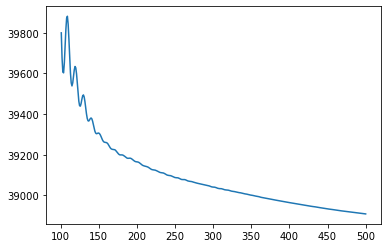

In [ ]:
start  = 100
mae_slice  = mae[start:]
epochs_slice = epochs[start:]
plt.plot(epochs_slice,mae_slice)
print(np.min(mae))


Editing Hyperparams to see if I can get a better value than for 256,256

In [ ]:
def hyperparam_investigator(epoch_num, layer_num,layer_shape,start = 100):
    
    model = build_model(layer_num,layer_shape)
    history = model.fit(train_data_x,train_data_y, validation_data= (val_data_x,val_data_y),epochs = epoch_num ,batch_size = 32,verbose = 0)
    mae = history.history['val_mean_absolute_error']
    train_err = history.history['loss']
    epochs = range(1,epoch_num+1)
    fig ,axs = plt.subplots(1,2, figsize = (10,5))
    axs[0].set_ylabel('Mean Absolute Error')
    axs[0].set_xlabel('Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss Function')
    mae_slice  = mae[start:]
    train_err_slice = train_err[start:]
    epochs_slice = epochs[start:]
    axs[0].plot(epochs_slice,mae_slice)
    axs[1].plot(epochs_slice,train_err_slice)
    print(np.min(mae))
hyperparam_investigator(300,3,[256,256,256])

NameError: name 'build_model' is not defined

In [ ]:
hyperparam_investigator(300,2,[128,128])

NameError: name 'build_model' is not defined

Adding a further Layer did not help with minimising the mae, I think just fiddling with the hyperparameters this evening is going to be a good idea

35609.188


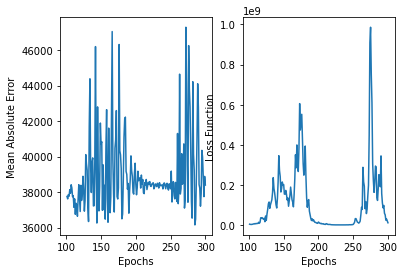

In [ ]:
hyperparam_investigator(300,3,[128,128,128])

37358.656


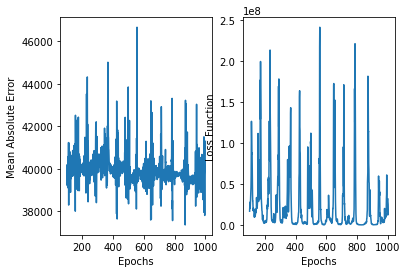

In [ ]:
hyperparam_investigator(1000,2,[64,64])

This is worth keeping clearly shows the overtraining. The results are worse than the first test. This is probably due to the lack of degrees of freedom that this model has. 

35560.473


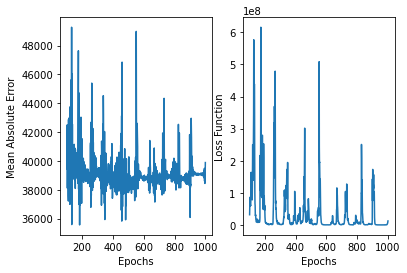

In [ ]:
hyperparam_investigator(1000,2,[128*3,128*3])

I think that this minimum is anomalous and this larger network is not the solution 

36957.414


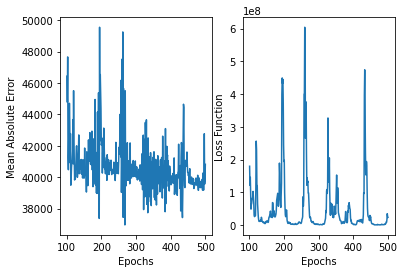

In [ ]:
hyperparam_investigator(500,2,[256,256])